# Theme : Deep Learning Models for Colorectal Cancer Detection and Classification Notebook
## Authors
- BELHADDAD mohamed islem (email: belhaddad.mohamed7@gmail.com)
- SAIM ouail (email: ouail.saim@gmail.com)

## Preamble
In this notebook, we built a deep learning model to classify images in the ["NCT-CRC-HE-100k"](https://zenodo.org/record/1214456) dataset, published by National Center for Tumor Diseases in Heidelberg, Germany, into <span style="color:#ff0077">9</span> different classes. We used a convolutional neural network architecture consisting of several convolutional and max pooling layers, followed by a dense layer with dropout and a softmax activation function for the output layer. We trained the model for <span style="color:#ff0077">10</span> epochs with a batch size of <span style="color:#ff0077">583</span> and used a validation set to monitor the training progress. We also used callbacks for checkpointing and reducing the learning rate on plateau. The model achieved a test accuracy of 98% on the ["NCT-CRC-HE-100k"](https://zenodo.org/record/1214456) dataset.


# Import Libraries

In [2]:
# Imports
import os, warnings, cv2
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
import pandas as pd

from os import listdir
from os.path import isfile, join
from shutil import rmtree

from tensorflow import keras
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification

# 1| Data Understanding

### 1.1| Load the directory 

In [3]:
main_path = 'C:\\Users\\Sc\\Desktop\\Colorectal_Cancer\\METHODOLOGY\\DATASET\\NCT-CRC-HE-100K'
# main_path = 'C:\\Users\\Sc\\Desktop\\Colorectal_Cancer\\METHODOLOGY\\DATASET\\CRC-VAL-HE-7K'

sub_dir =os.listdir(main_path)

By creating a Pandas dataframe from our data, we can easily shuffle, partially remove, or manipulate it without worrying about the size of the image data.

### 1.2| Create The DataFrame

In [4]:
Data_df=pd.DataFrame({'ID': [], 'Class':[]})

for subdir in sub_dir:
    mypath = join(main_path,subdir)
    files=[f for f in listdir(mypath)]
    classes=[subdir for c in files]
    files_df = pd.DataFrame({'ID':files, 'Class':classes})
    Data_df = Data_df.append(files_df)

Data_df

C:\Users\Sc\AppData\Local\Temp/ipykernel_3516/1151567093.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_df = Data_df.append(files_df)
C:\Users\Sc\AppData\Local\Temp/ipykernel_3516/1151567093.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_df = Data_df.append(files_df)
C:\Users\Sc\AppData\Local\Temp/ipykernel_3516/1151567093.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_df = Data_df.append(files_df)
C:\Users\Sc\AppData\Local\Temp/ipykernel_3516/1151567093.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_df = Data_df.append(files_df)
C:\Users\Sc\AppData\Local\Temp/ipykernel_3516/1151567093.py:8: Futur

,ID,Class
0,ADI-AAAMHQMK.tif,ADI
1,ADI-AACCGLYD.tif,ADI
2,ADI-AACVGRFT.tif,ADI
3,ADI-AADGNDRG.tif,ADI
4,ADI-AAEKWPVP.tif,ADI
...,...,...
14312,TUM-YYVTDICP.tif,TUM
14313,TUM-YYWKRFQQ.tif,TUM
14314,TUM-YYYCWNPT.tif,TUM
14315,TUM-YYYLHPLT.tif,TUM


### 1.3| Data Visualization
The problem can be better understood by visualizing the distribution of the data. In most cases, an imbalanced dataset cannot produce a quality model. However, in this case, the distribution does not seem to be a source of concern as shown below.

Furthermore, examining the patches within our data indicates that patches from different classes are easily distinguishable, suggesting that there should be no major issues in this regard.

In [5]:
# Distribution of the Classes
class_of_patch = Data_df.Class.value_counts()
print('the distribution of classes:\n{}'.format(class_of_patch[::-1]))

the distribution of classes:
NORM     8763
MUC      8896
ADI     10407
STR     10446
BACK    10566
DEB     11512
LYM     11557
MUS     13536
TUM     14317
Name: Class, dtype: int64


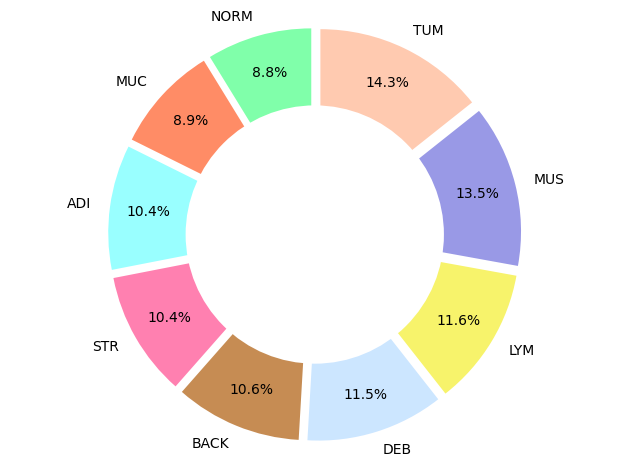

In [6]:
class_of_patch_labels = ['NORM','MUC','ADI','STR','BACK','DEB','LYM','MUS','TUM']
class_of_patch_values = class_of_patch[::-1]
colors = ['#80ffaa',
'#ff8c66',
'#99ffff',
'#ff80b0',
'#c68c53',
'#cce6ff',
'#f7f36b',
'#9999e6',
'#ffcab0']

# plt.pie(class_of_patch_values, labels=class_of_patch_labels, startangle=0, autopct='%1.1f')
#explsion
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
plt.pie(class_of_patch_values, colors=colors, labels=class_of_patch_labels, radius=0.75, startangle=90, autopct='%1.1f%%', pctdistance=0.8, explode = explode)

centre_circle = plt.Circle((0,0),0.5,color='black', fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# plt.title('Distribution of classes', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()


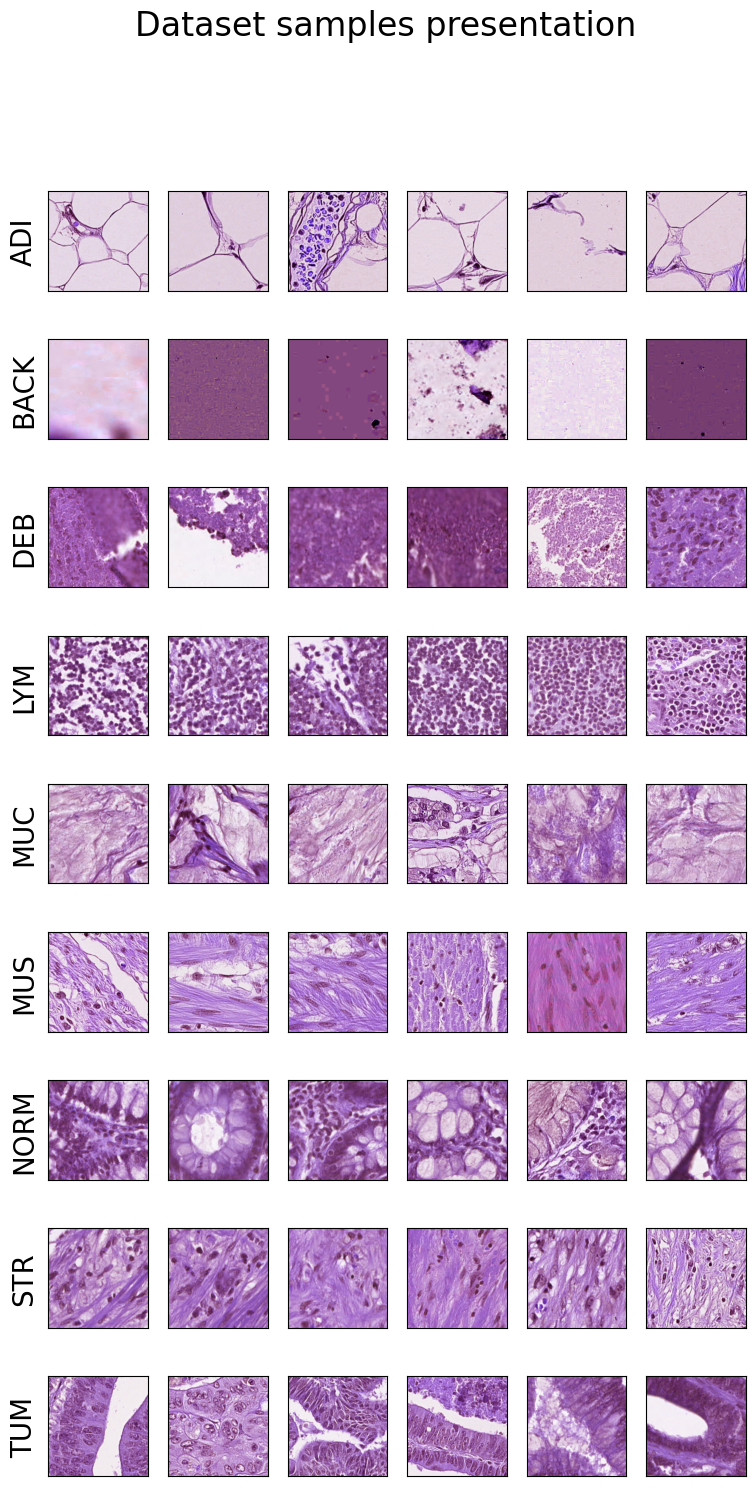

In [7]:
fig, axs = plt.subplots(9, 6, figsize=(9, 17))
fig.suptitle('Dataset samples presentation', size=24)

for i, cls in enumerate(sub_dir):
    samples = Data_df[Data_df['Class'] == cls].sample(6)
    for j, img_path in enumerate(samples['ID']):
        img = cv2.imread(join(main_path, cls, img_path))
        axs[i, j].imshow(img)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
    axs[i, 0].set_ylabel(cls, size=20)

### 1.4| Spliting The Data to Training and Validation Sets
On the basis of our dataframe, now we can split our dataset for the use of training, validation and testing. Further, we can plot quantities of each set to check for any imbalance between same classes of each set. Altough it is not necessary, because this issue is considered in the used module from sklearn library.

In [8]:
# Split into train and test
train_df, test_df = train_test_split(Data_df, test_size=0.15, random_state=42, shuffle=True, stratify=Data_df['Class'])

# Split train set into train and validation
train_df, val_df = train_test_split(train_df, test_size=0.176471, random_state=42, shuffle=True, stratify=train_df['Class'])

Class Distribution of Training Examples:
TUM     10021
MUS      9475
LYM      8090
DEB      8058
BACK     7396
STR      7312
ADI      7285
MUC      6228
NORM     6134
Name: Class, dtype: int64 

Class Distribution of Validation Examples:
TUM     2148
MUS     2031
LYM     1733
DEB     1727
BACK    1585
STR     1567
ADI     1561
MUC     1334
NORM    1315
Name: Class, dtype: int64 

Class Distribution of Test Examples:
TUM     2148
MUS     2030
LYM     1734
DEB     1727
BACK    1585
STR     1567
ADI     1561
MUC     1334
NORM    1314
Name: Class, dtype: int64 



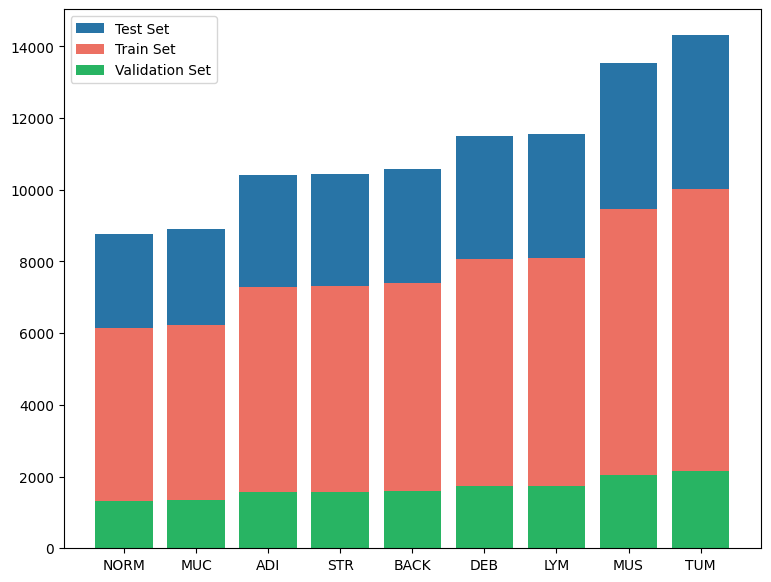

In [18]:
# Check the distribution of data in training and validation sets
train_val_test_data = [train_df, val_df, test_df]
data_names = ['Training', 'Validation', 'Test']

for i, data in enumerate(train_val_test_data):
    class_of_data_patch = data.Class.value_counts()
    print('Class Distribution of {} Examples:\n{}'.format(data_names[i], class_of_data_patch), '\n')
    
# Bar plot for checking the distribution
class_of_train_patch = train_df.Class.value_counts()
class_of_val_patch = val_df.Class.value_counts()
class_of_test_patch = test_df.Class.value_counts()

bar_fig, bar_axis = plt.subplots(figsize=(9,7))

sub_dir_list =  ['NORM', 'MUC', 'ADI', 'STR', 'BACK', 'DEB', 'LYM', 'MUS', 'TUM']

#66ff66, #ff8c66, #66a3ff

bar_axis.bar(sub_dir_list, class_of_patch[::-1], color='#2874A6', label='Test Set')
bar_axis.bar(sub_dir_list, class_of_train_patch[::-1], color='#EC7063', label='Train Set')
bar_axis.bar(sub_dir_list, class_of_val_patch[::-1], color='#28B463', label='Validation Set')

bar_axis.legend()


### 1.4.1| Creating Folders for the Splited Data
For Convinience. it is better to write the splitted sets of data to seperated directories. In that way,we could simply call them from the directory into our generator.

In [35]:
# # remove the SplittedData folder
# import shutil

# # dir_path = '/kaggle/working/SplittedData'

# shutil.rmtree(dir_path)

In [ ]:
main_dir = '/kaggle/working/SplittedData'

os.makedirs(main_dir, exist_ok=True)

train_dir = os.path.join(main_dir, 'Training')
os.makedirs(train_dir, exist_ok=True)

val_dir = os.path.join(main_dir, 'Validation')
os.makedirs(val_dir, exist_ok=True)

test_dir = os.path.join(main_dir, 'Test')
os.makedirs(test_dir, exist_ok=True)

for cls in sub_dir:
    train_sub_dir = os.path.join(train_dir, cls)
    os.makedirs(train_sub_dir, exist_ok=True)

    val_sub_dir = os.path.join(val_dir, cls)
    os.makedirs(val_sub_dir, exist_ok=True)

    test_sub_dir = os.path.join(test_dir, cls)
    os.makedirs(test_sub_dir, exist_ok=True)


### 1.4.2| Writing the splitted data in folders

In [37]:
from tqdm import tqdm
import shutil

Data_df.set_index('ID', inplace=True)

for img, label in tqdm(zip(train_df['ID'], train_df['Class']), desc='Copying train images'):
    source = join(main_path, label, img)
    dest = join(train_dir, label)
    shutil.copy(source, dest)

for img, label in tqdm(zip(val_df['ID'], val_df['Class']), desc='Copying validation images'):
    source = join(main_path, label, img)
    dest = join(val_dir, label)
    shutil.copy(source, dest)

for img, label in tqdm(zip(test_df['ID'], test_df['Class']), desc='Copying test images'):
    source = join(main_path, label, img)
    dest = join(test_dir, label)
    shutil.copy(source, dest)


Copying validation images: 15001it [01:38, 152.20it/s]
Copying test images: 15000it [01:38, 151.58it/s]
